#### Using GoogLeNet as a Classify All Model
Following GoogLeNet implementation from this [blog](https://ai.plainenglish.io/googlenet-inceptionv1-with-tensorflow-9e7f3a161e87)

Use GoogLeNet as a one-step classifier (all labels) for comparing with Yu paper models.  Data resized to 112x112 with no filters applied.  None type was undersampled randomly to 30,000 samples (same random seed as implemented Yu paper detect model).

In [1]:
# !pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, callbacks, Model

import os
import time
import numpy as np
import pandas as pd

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
tf.__version__

'2.3.4'

In [5]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:2', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:3', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [6]:
# specify variables
path = 'processed_data/googlenet'
filename = 'WM-clean-googlenet112'

result_path = 'results_matrix'
model_id = 'googlenet'
data_id = 'all112'
note = '' # -optional

x = 112
y = 112

In [7]:
# load dataset
from io import BytesIO
start = time.time()

data_key = f'{path}/{filename}.npz'
data_obj = my_bucket.Object(data_key).get()['Body'].read()
data = np.load(BytesIO(data_obj), allow_pickle=True)

print('Wall time: {:.3f} seconds'.format(time.time() - start))
data.files

Wall time: 0.697 seconds


['ids', 'labels', 'dataset', 'wafermap']

#### Data set-up

In [8]:
# prepare inputs
start = time.time()

x_train = data['wafermap'][data['dataset']=='train']
x_val = data['wafermap'][data['dataset']=='dev']
x_test = data['wafermap'][data['dataset']=='test']

print('Wall time: {:.3f} seconds'.format(time.time() - start))
print(f'Train: {x_train.shape}')
print(f'Dev: {x_val.shape}')
print(f'Test: {x_test.shape}')

Wall time: 10.710 seconds
Train: (47863, 112, 112, 1)
Dev: (25942, 112, 112, 1)
Test: (25943, 112, 112, 1)


In [9]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G       8.6G       231G        32M       1.8G       2.4G
-/+ buffers/cache:       4.4G       235G
Swap:           0B         0B         0B


In [10]:
# expand tensor and repeat 3 times
# images in greyscale, so no channel dimension
start = time.time()

x_train = tf.repeat(x_train, 3, axis=3)
x_val = tf.repeat(x_val, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 3])
print(f'Train: {x_train.shape}')
print(f'Dev: {x_val.shape}')
print(f'Test: {x_test.shape}')

Wall time: 3.16 seconds
Train: (47863, 112, 112, 3)
Dev: (25942, 112, 112, 3)
Test: (25943, 112, 112, 3)


In [11]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
start = time.time()

y_train = data['labels'][data['dataset']=='train']
y_val = data['labels'][data['dataset']=='dev']
y_test = data['labels'][data['dataset']=='test']

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: type = int, min = 0, max = 8
print(type(y_train[0]))
print(min(y_train), min(y_val), min(y_test))
print(max(y_train), max(y_val), max(y_test))

Wall time: 0.03 seconds
<class 'numpy.uint8'>
0 0 0
8 8 8


#### Model

In [12]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [13]:
inp = layers.Input(shape=(x, y, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(9, activation='softmax')(x)

In [14]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [15]:
model.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])

In [16]:
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=30)

Epoch 1/30
748/748 [==============================] - 51s 68ms/step - loss: 1.4730 - dense_4_loss: 0.9127 - dense_1_loss: 0.9556 - dense_3_loss: 0.9121 - dense_4_accuracy: 0.7280 - dense_1_accuracy: 0.7201 - dense_3_accuracy: 0.7322 - val_loss: 0.6723 - val_dense_4_loss: 0.4413 - val_dense_1_loss: 0.3676 - val_dense_3_loss: 0.4024 - val_dense_4_accuracy: 0.8825 - val_dense_1_accuracy: 0.9184 - val_dense_3_accuracy: 0.8849
Epoch 2/30
748/748 [==============================] - 48s 65ms/step - loss: 0.7247 - dense_4_loss: 0.4286 - dense_1_loss: 0.5443 - dense_3_loss: 0.4428 - dense_4_accuracy: 0.8669 - dense_1_accuracy: 0.8417 - dense_3_accuracy: 0.8667 - val_loss: 0.3040 - val_dense_4_loss: 0.1883 - val_dense_1_loss: 0.2144 - val_dense_3_loss: 0.1713 - val_dense_4_accuracy: 0.9419 - val_dense_1_accuracy: 0.9426 - val_dense_3_accuracy: 0.9491
Epoch 3/30
748/748 [==============================] - 48s 65ms/step - loss: 0.5275 - dense_4_loss: 0.2990 - dense_1_loss: 0.4252 - dense_3_loss: 0.3

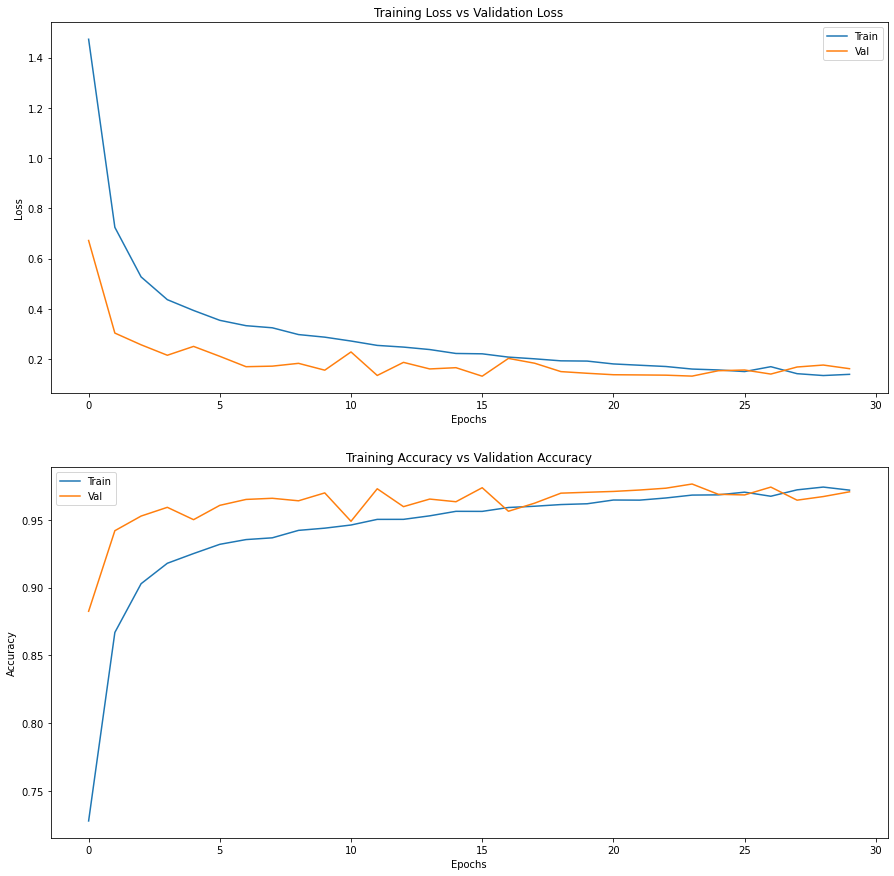

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [18]:
# save model to S3
s3_save_keras_model(model, f'{model_id}-{data_id}{note}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpqxnwt5lj/googlenet-all112/assets


In [19]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {:.2f} seconds".format(time.time() - start))
print(results)

811/811 [==============================] - 10s 12ms/step - loss: 0.1503 - dense_4_loss: 0.0895 - dense_1_loss: 0.1036 - dense_3_loss: 0.0992 - dense_4_accuracy: 0.9732 - dense_1_accuracy: 0.9711 - dense_3_accuracy: 0.9725
Wall time: 12.11 seconds
[0.15028977394104004, 0.08945223689079285, 0.10355615615844727, 0.09923581779003143, 0.9732490181922913, 0.9710904955863953, 0.9724781513214111]


In [20]:
# generate predictions for model analysis
start = time.time()
pred = model.predict(x_test)
y_pred = np.argmax(pred[0], axis=1)
predictions = [y_pred, pred]
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 7.999857425689697 seconds


In [21]:
# save predictions
# save to local instance
with open(f'{result_path}/{model_id}-{data_id}{note}.pkl', "wb") as f:
    pickle.dump(predictions, f)

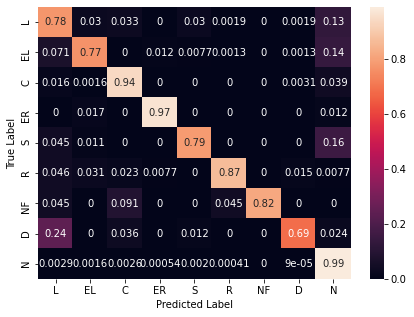

In [22]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_pred, mode='all', normalize=True)

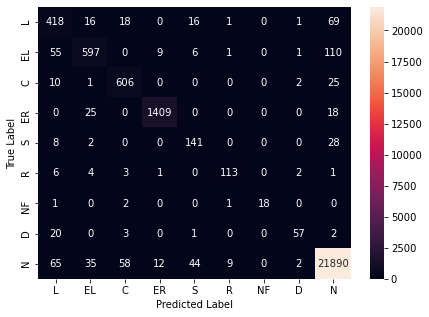

In [23]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_pred, mode='all', normalize=False)